In [1]:
import sys
sys.path.insert(0,'/Users/richardkoehler/Documents/GitHub/rk_neurology/python')
sys.path.insert(1,'/Users/richardkoehler/Documents/GitHub/icn/icn_m1/restructure')
import os

import json
import matplotlib.pyplot as plt
from mne_bids import (BIDSPath, read_raw_bids, write_raw_bids)
#import mne_bids
import mne
import numpy as np

import ieeg
import IO
import plot_ieeg

def icn_reref(raw, chans_leave_out, ref_used, prefix_r, prefix_l, prefix_ecog, mov_chan=None):
    """Rereference ECoG (common average) and LFP (bipolar) data. Return rereferenced raw instance.

    Keyword arguments:
    fname (string) -- filename including path of file in brainvision format

    Return:
    raw (MNE Raw instance) -- data in FIF format
    """

    # select file in bids format
    raw.load_data()
    
    ref_used = []
    ecog_ = []
    lfp_ = []
    
    for ch in raw.info['ch_names']:
        if ch in ref_used:
            ref_used.append(ch)
        if ch.startswith(prefix_ecog):
            ecog_.append(ch)
        elif ch.startswith(prefix_r) or ch.startswith(prefix_l):
            lfp_.append(ch)
    lfp_.sort()
    print('lfp_list: ', lfp_)

    # set channeltypes
    chan_type_set = {}
    chan_type_set = {ch: 'ecog' for ch in ecog_}
    chan_type_set.update({ch: 'seeg' for ch in lfp_})
    
    ch_picks = []
    
    if mov_chan is not None:
        raw.rename_channels({mov_chan:'MOV'})
    ind_mov = [ch for ch in raw.info['ch_names'] if ch.startswith('MOV') \
               or ch.startswith('ANALOG') or ch.startswith('ROT')]
    chan_type_set.update({mov: 'misc' for mov in ind_mov})
    
    for mov in ind_mov:
        ch_picks.append(mov)
    
    raw.set_channel_types(mapping=chan_type_set)

    # rereference and rename ECoG channels
    raw_ecog_reref = raw.copy().pick(ecog_).set_eeg_reference(ref_channels='average', projection=False,
                                                                  verbose=False)
    ecog_renaming_dict = {name: 'ECOG_' + name + '_r' for name in raw_ecog_reref.ch_names}
    raw_ecog_reref.rename_channels(ecog_renaming_dict)
    raw.add_channels([raw_ecog_reref], force_update_info=True)
    for name in raw_ecog_reref.ch_names:
        ch_picks.append(name)

    # rereference 
    for index, chan in enumerate(lfp_):
        if chan not in chans_leave_out:
            ref_chan = lfp_[index-1]
            if ref_chan not in ref_used:
                raw_reref = raw.copy().pick([ref_chan, chan]).set_eeg_reference(
                    ref_channels=[ref_chan], projection=False, verbose=False)
                new_chan = 'LFP_' + chan + '_r'
                raw_reref.rename_channels({chan: new_chan})
                raw.add_channels([raw_reref.pick([new_chan])], force_update_info=True)
                ch_picks.append(new_chan)
            else:
                raw_reref = raw.copy().pick([chan])
                new_chan = 'LFP_' + chan + '_r'
                raw_reref.rename_channels({chan: new_chan})
                raw.add_channels([raw_reref.pick([new_chan])], force_update_info=True)
                ch_picks.append(new_chan)
                
    raw.reorder_channels(sorted(ch_picks))
    return raw

In [2]:
event_id = {'Movement_Onset':1, 'Movement_End':-1}
event_desc = {v: k for k, v in event_id.items()}

bids_root = '/Users/richardkoehler/Documents/Neurology_Data/BIDS Beijing raw/'
deriv_root = '/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives'

#bids_file = BIDSPath(subject=subject, session=session, task=task, run=run, root=bids_root)
#deriv_bids = BIDSPath(subject=subject, session=session, task=task, run=run, root=deriv_root)

# Enter filename and Bids path
def get_files(path, prefix):
    """
    """
    vhdr_files = IO.get_all_ieeg_files(path)
    list_bp = []
    for vhdr_file in vhdr_files:
        subject, session, task, run = ieeg.get_subject_sess_task_run(os.path.basename(vhdr_file))
        #print('Subject: ', subject, '\nSession: ', session, '\nTask: ', task, '\nRun: ', run)
        if task.startswith(prefix):
            list_bp.append(os.path.basename(vhdr_file))
    return list_bp

In [3]:
list_bp = get_files(bids_root, prefix='but')
print(list_bp)

['sub-FOG013_ses-postimp_task-buttonPress_run-01_eeg.edf', 'sub-FOG006_ses-postimp_task-buttonPress_run-01_eeg.edf', 'sub-FOG008_ses-postimp_task-buttonPress_run-01_eeg.edf', 'sub-FOG010_ses-postimp_task-buttonPress_run-01_eeg.edf', 'sub-FOG011_ses-postimp_task-buttonPress_run-01_eeg.edf', 'sub-FOGC001_ses-postimp_task-buttonPress_run-01_eeg.edf']


In [8]:
subject, session, task, run = ieeg.get_subject_sess_task_run(list_bp[0])
bids_file = BIDSPath(subject=subject, session=session, task=task, run=run, root=bids_root)
deriv_bids = BIDSPath(subject=subject, session=session, task=task, run=run, root=deriv_root)

deriv_bids.update(datatype='ieeg', processing='reref'+'raw')
raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)

#raw = read_raw_bids(bids_path=bids_file, extra_params=dict(preload=True), verbose=False)
#raw = mne.io.read_raw_edf('/Users/richardkoehler/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/Datasets/BIDS Peking/sub-FOG013/ses-postimp/ieeg/sub-FOG013_ses-postimp_task-buttonPress_run-01_ieeg.edf')
#raw = mne.io.read_raw_brainvision(vhdr_files[2])
plot = False
if plot == True:
    %matplotlib qt
    raw.load_data()
    plt.style.use('default')
    raw.plot(duration=120.0,block=True, title='highpass: 0.1', scalings='auto', highpass=0.1, decim=5)

Extracting parameters from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG013/ses-postimp/ieeg/sub-FOG013_ses-postimp_task-buttonPress_run-01_proc-rerefraw_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG013/ses-postimp/ieeg/sub-FOG013_ses-postimp_task-buttonPress_run-01_proc-rerefraw_events.tsv.
Reading channel info from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG013/ses-postimp/ieeg/sub-FOG013_ses-postimp_task-buttonPress_run-01_proc-rerefraw_channels.tsv.


<ipython-input-8-233296fd8a8c>:6: RuntimeWarning: Did not find any coordsystem.json associated with sub-FOG013_ses-postimp_task-buttonPress_run-01_proc-rerefraw.

The search_str was "/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG013/**/sub-FOG013_ses-postimp*coordsystem.json"
  raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)


In [7]:
#raw = icn_reref(raw, ['POL RD1','POL LD1'], ['POL RS5', 'POL RS6'], 'POL RD', 'POL LD', 'POL RS', 'POL DC10')
raw = icn_reref(raw, ['POL RD1','POL LD1U', 'POL LD1D'], ['POL LD1'], 'POL RD', 'POL LD', 'POL RS', 'POL DC10')
if subject == FOG011:
    raw.crop(tmax=420.0)
#%matplotlib qt
#raw.load_data()
#plt.style.use('default')
#raw.plot(duration=120.0,block=False, title='Hpass 0.1', scalings='auto', highpass=0.1, decim=5)

lfp_list:  ['POL LD1D', 'POL LD1U', 'POL LD2', 'POL LD3', 'POL LD4', 'POL RD1', 'POL RD2', 'POL RD3', 'POL RD4']


In [254]:
deriv_bids.update(datatype='ieeg', processing='reref'+'raw')
fname_fif = os.path.join(deriv_bids.directory, deriv_bids.basename+ '.fif')
if not os.path.exists(os.path.dirname(fname_fif)):
    os.makedirs(os.path.dirname(fname_fif))
raw.save(fname_fif, overwrite=True)
raw = mne.io.read_raw_fif(fname_fif, preload=False, verbose=False)
write_raw_bids(raw, deriv_bids, anonymize=None, overwrite=True, verbose=False)
if os.path.exists(fname_fif):
    os.remove(fname_fif)
raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)

Writing /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG008/ses-postimp/ieeg/sub-FOG008_ses-postimp_task-buttonPress_run-01_proc-rerefraw.fif
Closing /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG008/ses-postimp/ieeg/sub-FOG008_ses-postimp_task-buttonPress_run-01_proc-rerefraw.fif
[done]
Extracting parameters from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG008/ses-postimp/ieeg/sub-FOG008_ses-postimp_task-buttonPress_run-01_proc-rerefraw_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG008/ses-postimp/ieeg/sub-FOG008_ses-postimp_task-buttonPress_run-01_proc-rerefraw_events.tsv.
Reading channel info from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivati

<ipython-input-254-ada66a13add5>:10: RuntimeWarning: Did not find any coordsystem.json associated with sub-FOG008_ses-postimp_task-buttonPress_run-01_proc-rerefraw.

The search_str was "/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG008/**/sub-FOG008_ses-postimp*coordsystem.json"
  raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)


In [181]:
subject, session, task, run = ieeg.get_subject_sess_task_run(list_bp[4])
bids_file = BIDSPath(subject=subject, session=session, task=task, run=run, root=bids_root)
deriv_bids = BIDSPath(subject=subject, session=session, task=task, run=run, root=deriv_root)
deriv_bids.update(datatype='ieeg', processing='reref'+'raw')
raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)

Extracting parameters from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_events.tsv.
Reading channel info from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_channels.tsv.


<ipython-input-181-48c58d692b9a>:5: RuntimeWarning: Did not find any coordsystem.json associated with sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw.

The search_str was "/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/**/sub-FOG011_ses-postimp*coordsystem.json"
  raw = read_raw_bids(bids_path=deriv_bids, extra_params=dict(preload=False), verbose=False)


In [182]:
preprocess = False
if preprocess is True:
    # Get recropped data, preprocess using modified script by TM
    # Enter Resampling Rate as sfreq
    sfreq = 10
    f_bands = ['theta', 'alpha', 'low beta', 'high beta', 'low gamma', 'HFA']
    ch_names = raw.copy().pick(picks='data').info['ch_names']
    outpath = os.path.join(deriv_bids.root,'derivatives')
    xf_zs_r, ml_zs_r, sfreq = ieeg.write_out_raw(str(deriv_bids.fpath), outpath, var_rolling_window=1, session=session, resampling_rate=sfreq, test_LM=False, \
                                                      resampling=True, write_json=True, normalize=False)
else:
    # If preprocess is skipped, because already done, import raw data from json file
    outpath = os.path.join(deriv_bids.root,'derivatives', 'var-1000ms_sampfreq10Hz')
    data_dict = ieeg.retrieve_data(outpath, deriv_bids.basename)
    events_dict = ieeg.retrieve_events(outpath, deriv_bids.basename)
    raw = read_raw_bids(deriv_bids, extra_params=dict(preload=False), verbose=False)
    xf_zs_r = np.asarray(data_dict['data'])
    ml_zs_r = np.asarray(data_dict['true_movements'])
    sfreq = data_dict['sampling_rate']
    ch_names = data_dict['ch_names']
    f_bands = data_dict['f_bands']
    event_id = events_dict['event_id']
    events_arr = np.asarray(events_dict['events'])
    labels = np.asarray(events_dict['labels'])

Extracting parameters from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_ieeg.vhdr...
Setting channel info structure...
Reading events from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_events.tsv.
Reading channel info from /Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/ses-postimp/ieeg/sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw_channels.tsv.


<ipython-input-182-073906bb6750>:16: RuntimeWarning: Did not find any coordsystem.json associated with sub-FOG011_ses-postimp_task-buttonPress_run-01_proc-rerefraw.

The search_str was "/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/sub-FOG011/**/sub-FOG011_ses-postimp*coordsystem.json"
  raw = read_raw_bids(deriv_bids, extra_params=dict(preload=False), verbose=False)


>>baseline_als is being used
tshape=  (4189,)
index_start=  (4189,)
id_event:  (130,)
time_event:  (130,)
Number of detected events:  65.0


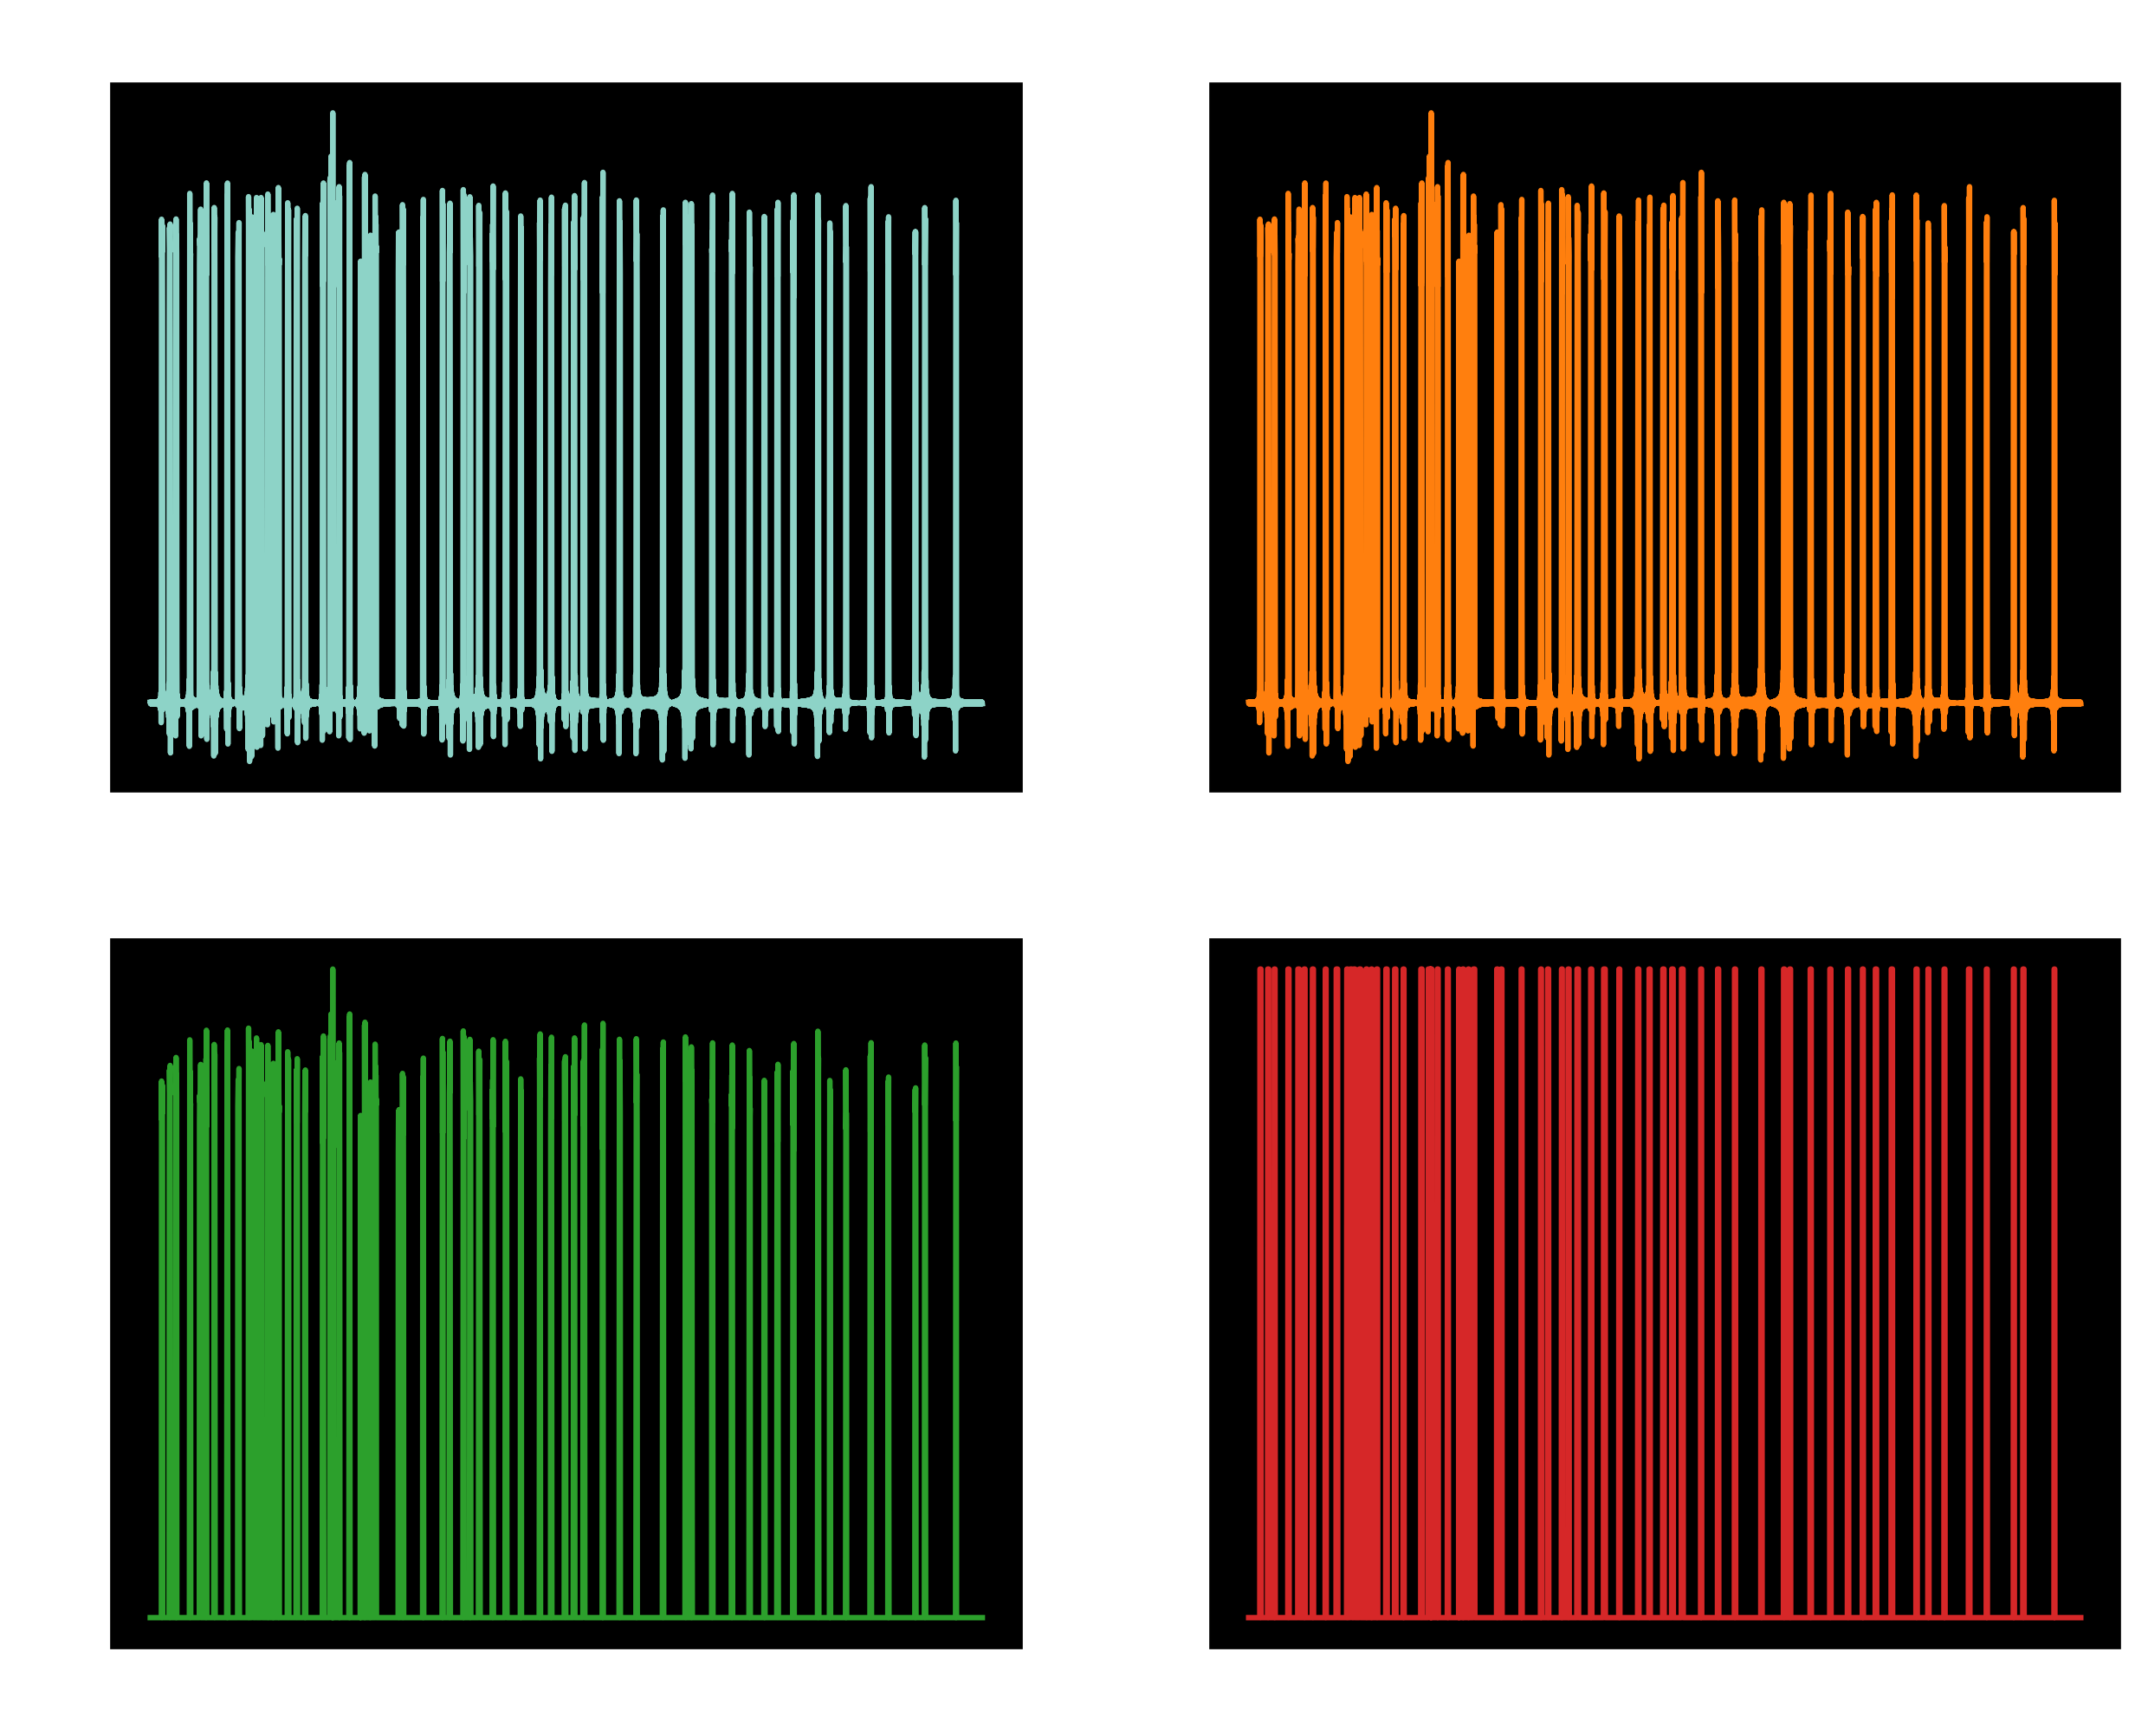

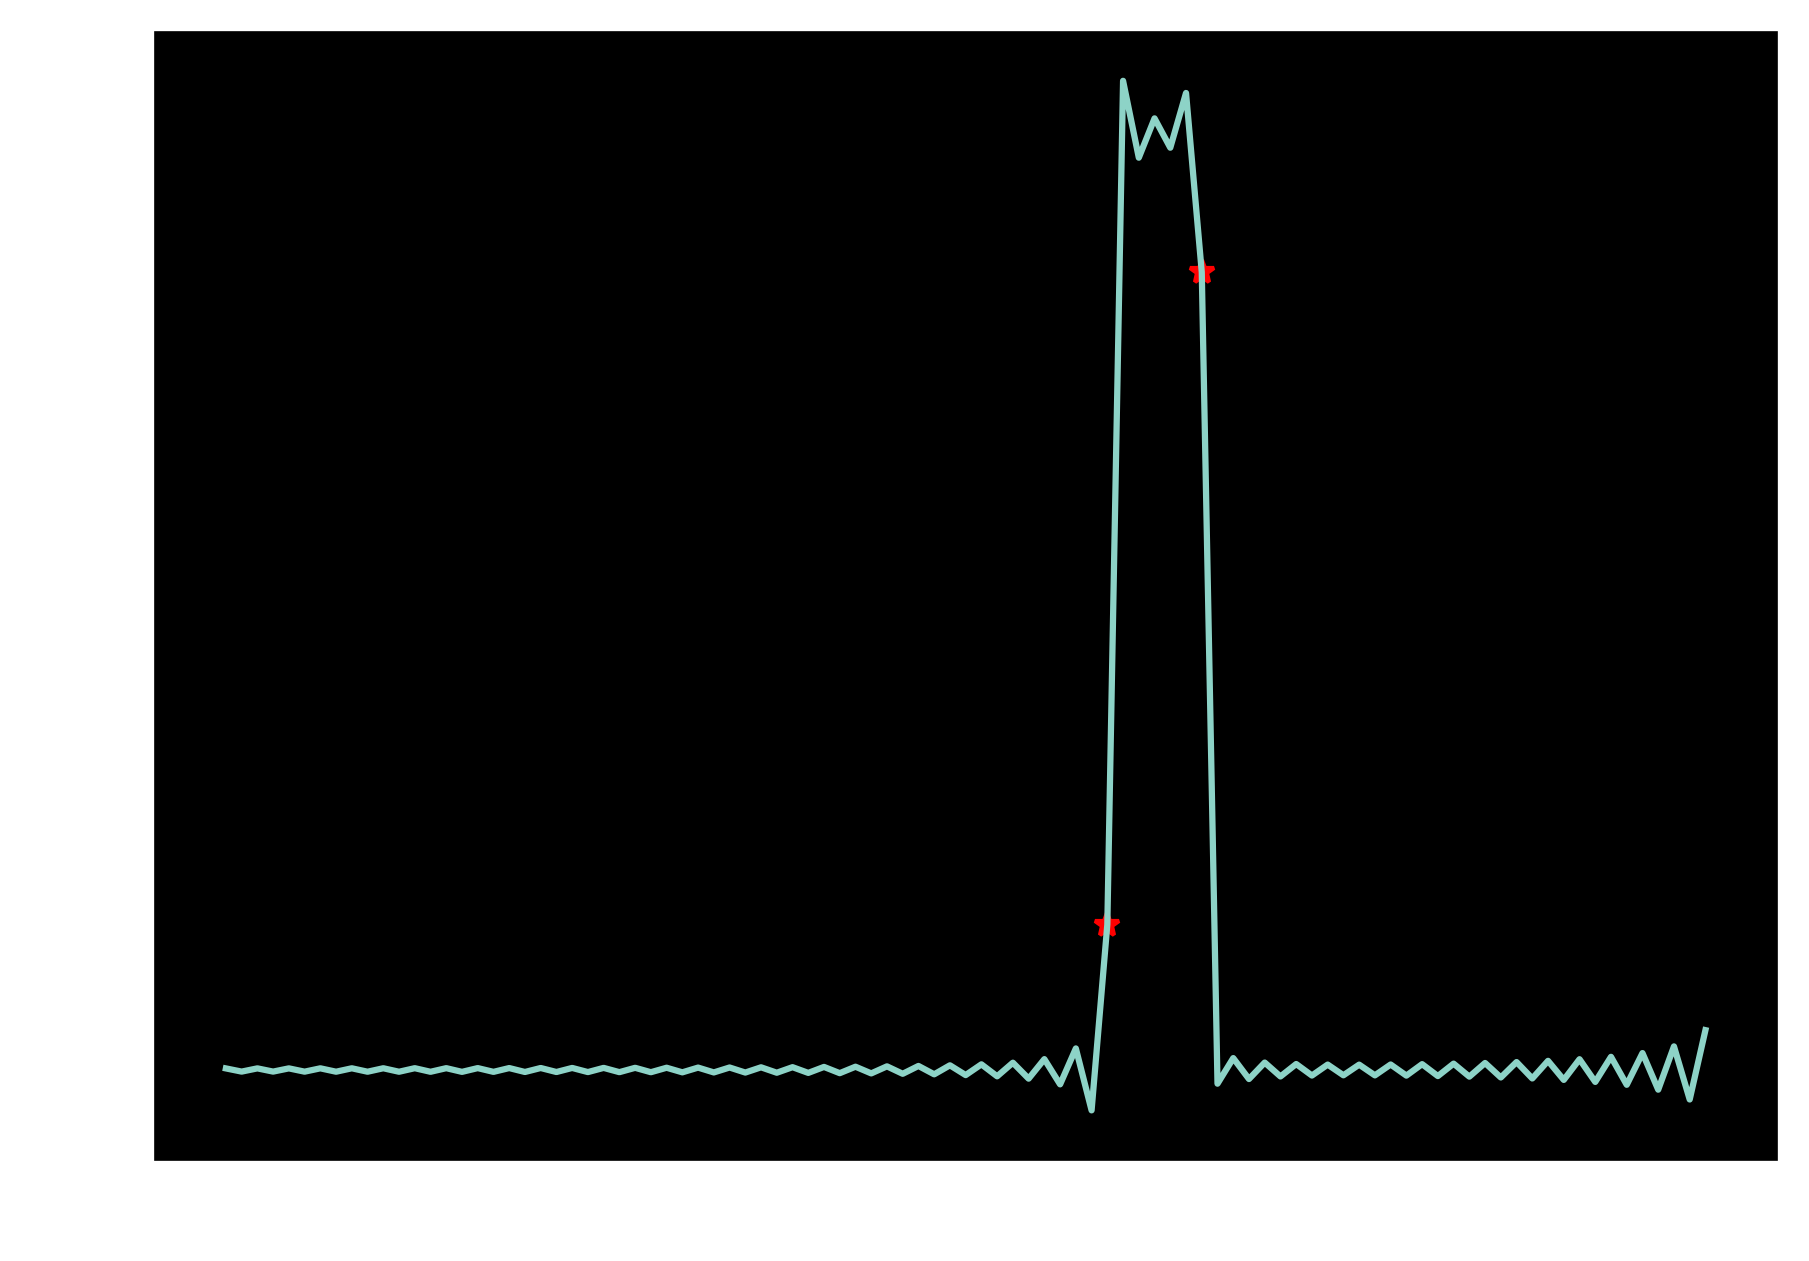

In [183]:
%matplotlib inline
events_arr = ieeg.get_events(ml_zs_r, method='baseline_als', param=[1e3, 1e-4], thr=1.8e-1, invertrota=False, decimate=1)
plot = False
if plot == True:
    # Now plot and check accuracy
    %matplotlib inline
    mov_raw = ml_zs_r[0,:].T
    #events_arr=events_mne
    for i in range(0,events_arr.shape[0],2):
        print(i)
        plt.plot(events_arr[i:i+2, 0], mov_raw[events_arr[i:i+2, 0]], 'r*')
        plt.plot(mov_raw[:events_arr[i+1, 0]+50])
        plt.xlim((events_arr[i, 0]-50,events_arr[i+1, 0]+50))
        plt.show()

In [179]:
labels, groups = ieeg.generate_continous_label_array(xf_zs_r.shape[2], 1, events_arr)
events_dict = {
            "subject": subject,
            "sess": session,
            "task": task,
            "run": run,
            "sampling_rate": sfreq,
            "event_id": event_id,
            "events": events_arr.tolist(),
            "labels": labels.tolist(),
            "groups": groups.tolist()
            }
outpath_file = os.path.join(outpath, 'evs_xfzs_' + 'sub-' + subject +'_sess-' + session + '_task-' + task + '_run-' + run + '.json')
with open(outpath_file, 'w') as fp:
    json.dump(events_dict, fp)

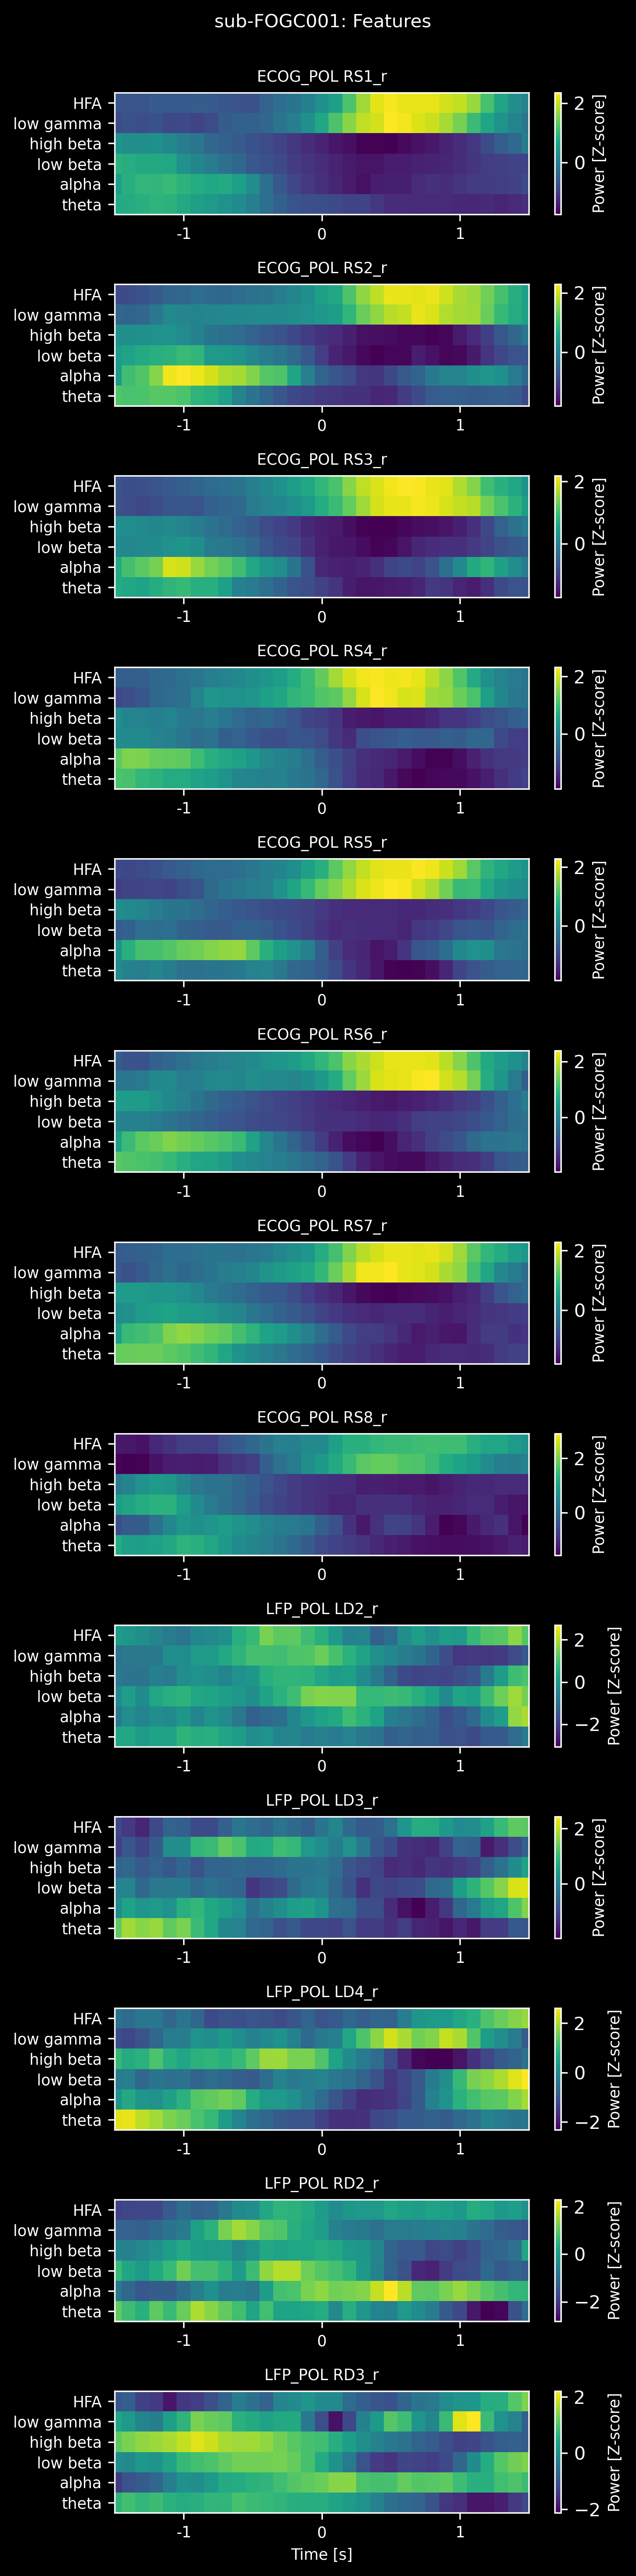

In [180]:
%matplotlib inline
plot_feat(xf_zs_r.T, labels, str(bids_file.basename), chans=ch_names[0:-1], \
                    feats=f_bands, sfreq=sfreq, epoch_len=3, xlim_l=-1.5, xlim_h=1.5, print_plot=True, outpath=outpath)

xfzs_sub-FOG006_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOG006_sess-postimp_task-buttonPress_run-01.json


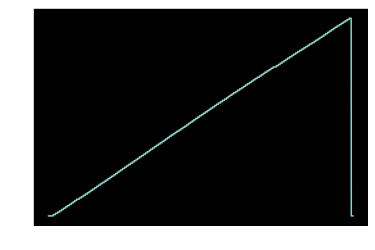

xfzs_sub-FOG008_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOG008_sess-postimp_task-buttonPress_run-01.json


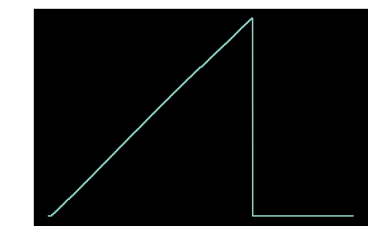

xfzs_sub-FOG010_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOG010_sess-postimp_task-buttonPress_run-01.json


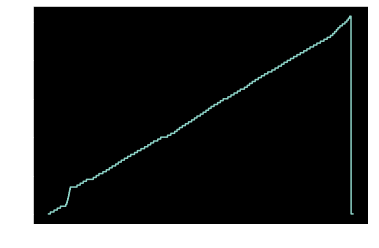

xfzs_sub-FOG011_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOG011_sess-postimp_task-buttonPress_run-01.json


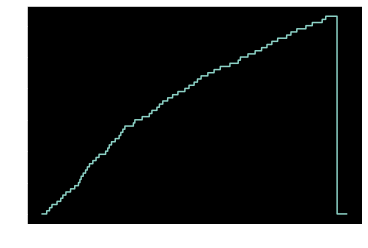

xfzs_sub-FOG013_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOG013_sess-postimp_task-buttonPress_run-01.json


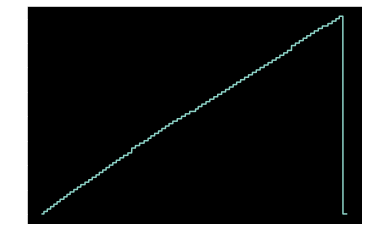

xfzs_sub-FOGC001_sess-postimp_task-buttonPress_run-01.json evs_xfzs_sub-FOGC001_sess-postimp_task-buttonPress_run-01.json


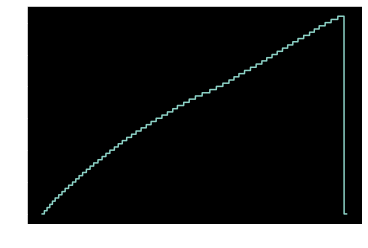

In [251]:
import json
import os

def get_json_files(path):
    """Return individual paths to all data and events json files in given directory.
    
    Arguments
    ---------
    path (string/path) : Path to directory where json files are located.
    
    Returns
    -------
    data_ (list) : Sorted list of all json data files
    evs_ (list) : Sorted list of all json events files
    """
    data_ = []
    evs_ = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".json"):
                if file.startswith('evs'):
                    evs_.append(os.path.join(root, file))
                else:
                    data_.append(os.path.join(root, file))
    data_.sort()
    evs_.sort()
    return data_, evs_

inpath = '/Users/richardkoehler/OneDrive - Charité - Universitätsmedizin Berlin/BIDS Beijing derivatives/derivatives'
outpath = inpath
data_list, events_list = get_json_files(path=inpath)

for ind, data in enumerate(data_list):
    print(os.path.basename(data_list[ind]), os.path.basename(events_list[ind]))
    subject, session, task, run = get_subject_sess_task_run(os.path.basename(data_list[ind]))
    with open(events_list[ind]) as json_file:
        events_dict = json.load(json_file)
    with open(data_list[ind]) as json_file:
        data_dict = json.load(json_file)    
    events_arr = np.asarray(events_dict['events'])
    ml_zs_r = np.asarray(data_dict['true_movements'])
    labels, groups = generate_continous_label_array(ml_zs_r.shape[1], 1, events_arr)
    plt.plot(groups.T)
    plt.show()
    events_dict.update({'groups':groups.tolist()})
    outpath_file = os.path.join(outpath, 'evs_xfzs_' + 'sub-' + subject +'_sess-' + session + '_task-' + task + '_run-' + run + '.json')
    with open(outpath_file, 'w') as fp:
        json.dump(events_dict, fp)

In [193]:
def get_subject_sess_task_run(vhdr_file):
    """ Given a vhdr filename (as a string) return the including subject, session, task and run.
    
    Args:
        vhdr_file (string): [description]
    Return:
        subject, sess, task, run
    """
    
    subject = vhdr_file[vhdr_file.find('sub-')+4:vhdr_file.find('ses')-1]

    str_sess = vhdr_file[vhdr_file.find('ses'):]
    sess = str_sess[str_sess.find('-')+1:str_sess.find('_')]
      
    str_task = vhdr_file[vhdr_file.find('task'):]
    task = str_task[str_task.find('-')+1:str_task.find('run')-1]
    
    str_run = vhdr_file[vhdr_file.find('run'):]
    run = str_run[str_run.find('-')+1:str_run.find('.')]
  
    return subject, sess, task, run

In [116]:
from scipy import stats
from matplotlib import pyplot as plt
import os.path as od


def plot_feat(data, label_ar, fname, chans, feats, sfreq, epoch_len, xlim_l, xlim_h, print_plot=False, outpath=None):
    """Plot features for each channel, time-locked at onset of events and averaged over trials.

    Keyword arguments
    -----------------
    data (Numpy array) : data in the shape (samples,channels,features)
    label_ar (Numpy array) : array containing labels for all samples (e.g. 1 is movement, 0 is no movement)
    chans (list) : list of channel names
    feats (list) : list of feature names
    sfreq (int) : sampling frequency of data
    epoch_len (int) : length of epochs to be created
    xlim_l (int/float) : lower limit in seconds of epochs to be plotted
    xlim_h (int/float) : higher limit in seconds of epochs to be plotted
    print_plot (boolean) : save figure as .png (default=False)
    outpath ('string') : folder path to save figure

    Returns
    -------
    None
    """
    
    subject, session, task, run = ieeg.get_subject_sess_task_run(fname)
    feat_concat, mov_concat = plot_ieeg.get_epochs(data, label_ar, threshold=0, epoch_len=epoch_len, sfreq=sfreq)

    mean_feat = feat_concat.mean(axis=0)
    for ch in range(mean_feat.shape[1]):
        for feat in range(mean_feat.shape[2]):
            mean_feat[:,ch,feat] = stats.zscore(mean_feat[:,ch,feat])

    plt.style.use('dark_background')
    fig = plt.figure(dpi=300,figsize=(5, len(chans)*1.5)) 
    fig.suptitle('sub-' + subject + ': Features', y = 1, fontsize='medium')
    xlab = np.arange(-epoch_len, epoch_len+1, 1, dtype=int)
    xlim1, xlim2= (epoch_len+xlim_l)*sfreq, (epoch_len+xlim_h)*sfreq

    for i, chan in enumerate(chans):
        ax = fig.add_subplot(len(chans),1,i+1)
        plt.title(chan, fontsize='small')
        plt.imshow(mean_feat[:,i,:].T, aspect='auto', interpolation=None)
        cbar = plt.colorbar()
        cbar.set_label('Power [Z-score]', fontsize='small')
        plt.xticks(np.arange(0, (epoch_len*2+1)*sfreq, sfreq), xlab, fontsize='small')
        plt.yticks(range(mean_feat.shape[2]),feats, fontsize='small')
        plt.xlim(xlim1, xlim2)
        plt.gca().invert_yaxis()

    plt.xlabel('Time [s]', fontsize='small')
    plt.tight_layout()
    if print_plot == True:
        fig.savefig(od.join(outpath, 'sub-' + subject +'_sess-' + session + '_task-' + task + '_run-' + run + '_features' + '.png'))
    plt.show()

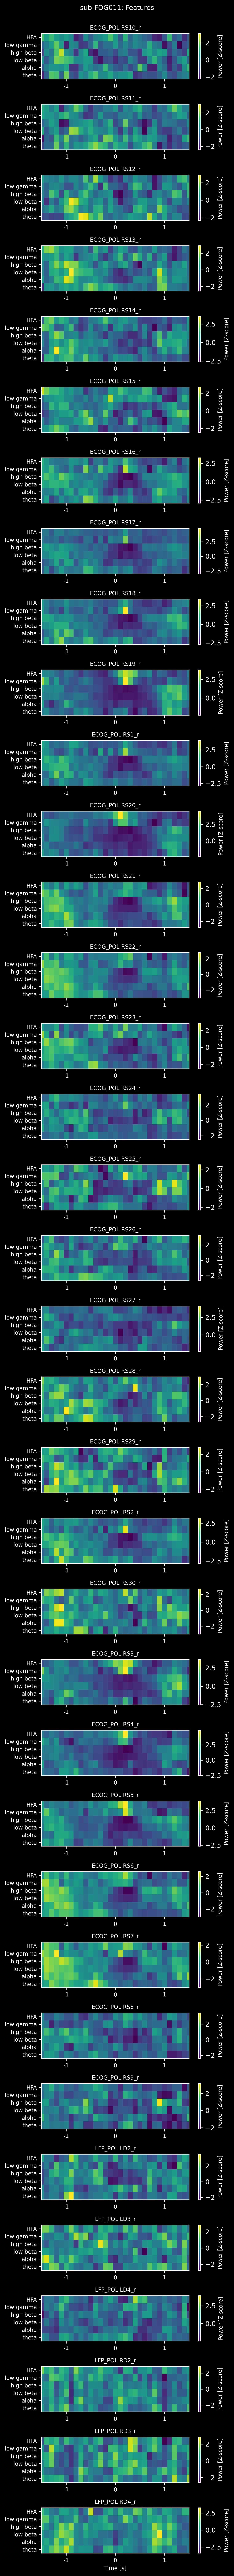

In [87]:
%matplotlib inline
plot_feat(xf_zs_r.T, labels, str(bids_file.basename), chans=ch_names, \
                    feats=f_bands, sfreq=sfreq, epoch_len=3, xlim_l=-1.5, xlim_h=1.5, print_plot=True, outpath=outpath)

(4199, 216)


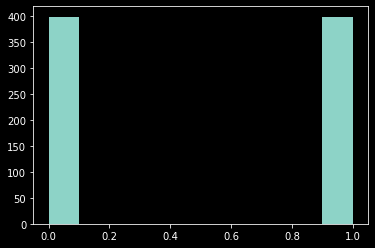

CV-AP:  0.6884852128471765 CV-Accuracy:  0.6557625786163521


In [88]:
import pandas as pd
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, StratifiedKFold


Xm = xf_zs_r[:,0,:]
for i in np.arange(1,xf_zs_r.shape[1]):
    Xm = np.vstack((Xm, xf_zs_r[:,i,:]))
Xm = Xm.T
print(Xm.shape)

df1 = pd.DataFrame(data=labels, columns=['label'])
df2 = pd.DataFrame(data=Xm)
df_join = df1.join(df2)
value_counts = df_join['label'].value_counts()
df_majority = df_join[df_join.label==value_counts.index[0]]
df_minority = df_join[df_join.label==value_counts.index[1]]
df_maj_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority),random_state=123)
df_downsampled = pd.concat([df_maj_downsampled, df_minority])
# Separate input features (X) and target variable (y)
y_ds = df_downsampled.label
X_ds = df_downsampled.drop('label', axis=1)
# plot label distribution
plt.hist(y_ds)
plt.show()

clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
#kf = KFold(n_splits = 10, shuffle=True)
scores = cross_validate(clf, X_ds, y_ds, scoring=['average_precision', 'accuracy'])
print('CV-AP: ', np.mean(scores['test_average_precision']), 'CV-Accuracy: ', np.mean(scores['test_accuracy']))

In [158]:
def concat_feats(X):
    """Concatenate data from 3-D array to 2-D array and transpose. Useful for using scikit classifiers.
    
    Arguments
    ---------
    X (numpy array) : Array of shape (n_features, n_channels, n_samples).
    
    Returns
    -------
    Xm (numpy array) : Array of shape (n_samples, n_features*n_channels).
    """
    feats = X.shape[0]
    chans = X.shape[1]
    samps = X.shape[2]
    Xm = np.zeros((feats*chans,samps))
    for chan in range(chans):
        Xm[chan*feats:(chan+1)*feats,:] = X[:,chan,:]
    Xm = Xm.T
    return Xm

def classify(X, labels, groups, lfp_chs, run):
    """Balance labels and classify with shrinkage LDA. Return 10-fold shuffled cross-val. mean-AP and accuracy.
    
    Arguments
    ---------
    X (numpy array) : Array of shape (n_features, n_channels, n_samples). ECOG channels come first, LFP channels last.
    labels (numpy array) : Array of labels of shape (n_samples). Must have same num. of samples as X.
    lfp_chs (integer) : Number of LFP channels.
    run (string) : Either 'All', 'All ECoG' or 'All LFP'. 
    
    Returns
    -------
    mean_ap (float) : 10-fold cross validated mean_ap
    accuracy (float) : Sorted list of all json events files
    """
    if run == 'All':
        Xm = concat_feats(X)
    elif run == 'All ECoG':
        Xm = concat_feats(X[:,0:-lfp_chs,:])
    elif run == 'All LFP':
        Xm = concat_feats(X[:,-lfp_chs:,:])
    
    df3 = pd.DataFrame(data=groups, columns=['group'])
    df1 = pd.DataFrame(data=labels, columns=['label'])
    df2 = pd.DataFrame(data=Xm)
    df_join = df1.join([df2, df3])
    value_counts = df_join['label'].value_counts()
    df_majority = df_join[df_join.label==value_counts.index[0]]
    df_minority = df_join[df_join.label==value_counts.index[1]]
    df_maj_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority))
    df_downsampled = pd.concat([df_maj_downsampled, df_minority])
    # Separate input features (X) and target variable (y)
    y = df_downsampled.label
    group = df_downsampled.group
    X = df_downsampled.drop(['label','group'], axis=1)
    clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    cv = GroupKFold(n_splits=10)
    #cv = StratifiedKFold(n_splits = 10, shuffle=True)
    scores = cross_validate(clf, X, y, cv=cv, groups=group, scoring=['average_precision', 'accuracy'])
    mean_ap = round(np.mean(scores['test_average_precision']),3)
    accuracy = round(np.mean(scores['test_accuracy']),3)
    return mean_ap, accuracy

All 0.84 0.82
All ECoG 0.838 0.819
All LFP 0.712 0.694


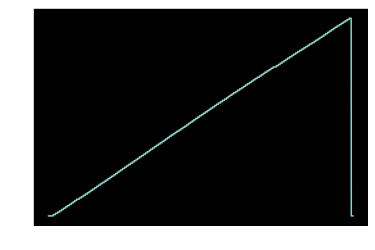

In [242]:
labels, groups = generate_continous_label_array(xf_zs_r.shape[2], 1, events_arr)
plt.plot(groups.T)
items = ['All', 'All ECoG', 'All LFP']
for item in items:
    mean_ap, accuracy = classify(xf_zs_r, labels, groups, 6, item)
    print (item, mean_ap, accuracy)

In [161]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
from matplotlib.patches import Patch

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")
    
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 5

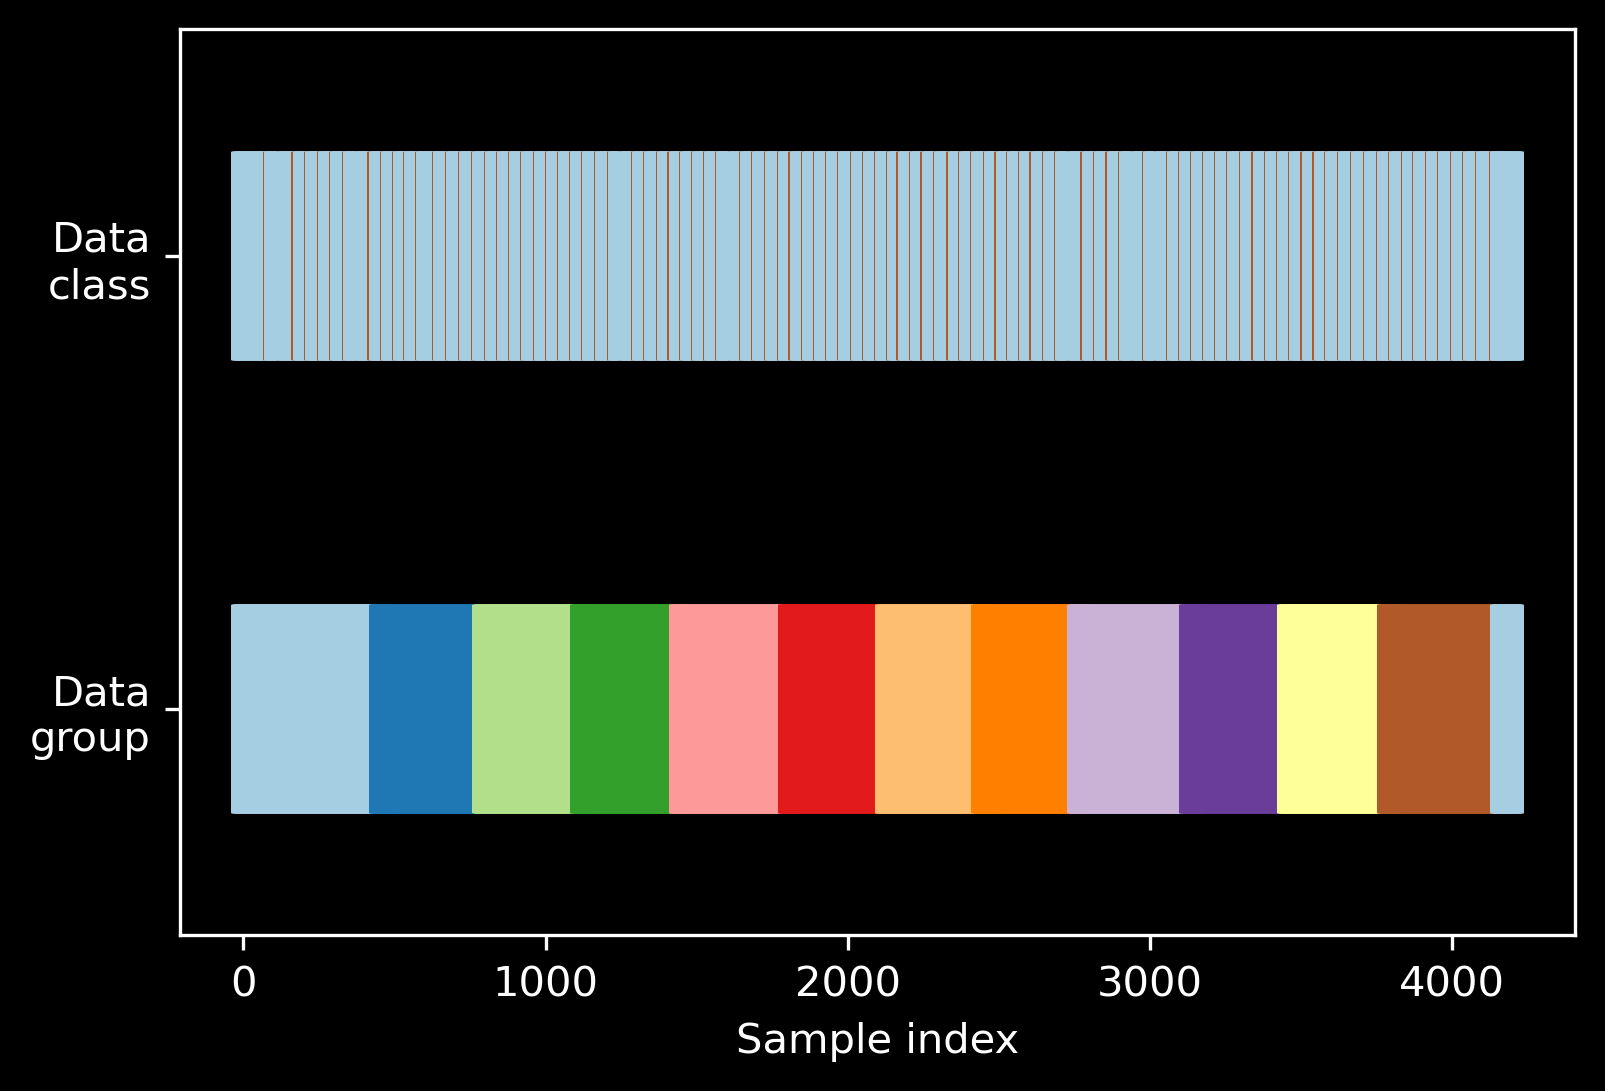

In [102]:
visualize_groups(labels, groups, 'no groups')

(4199, 84)


<AxesSubplot:title={'center':'GroupKFold'}, xlabel='Sample index', ylabel='CV iteration'>

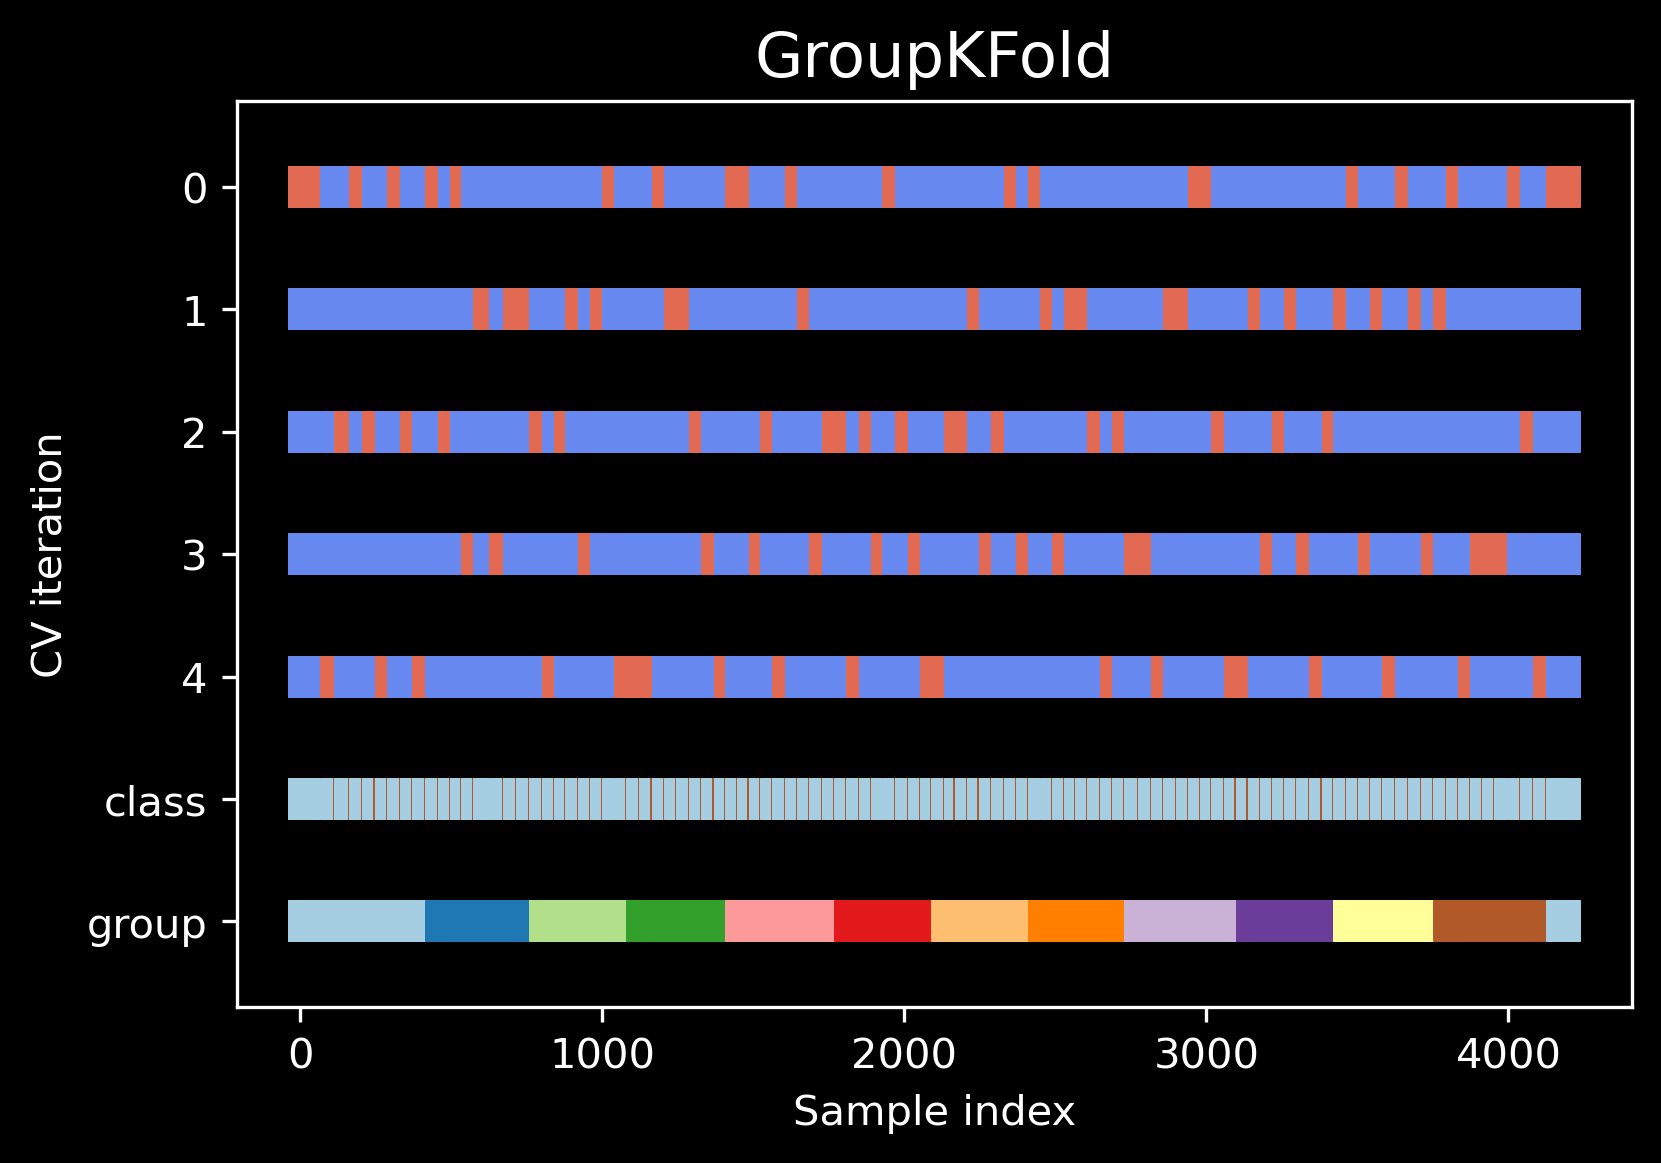

In [112]:
Xm = xf_zs_r[:,0,:]
for i in np.arange(1,xf_zs_r.shape[1]):
    Xm = np.vstack((Xm, xf_zs_r[:,i,:]))
Xm = Xm.T
print(Xm.shape)
X = Xm
y = labels
fig, ax = plt.subplots(dpi=300)
cv = GroupKFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

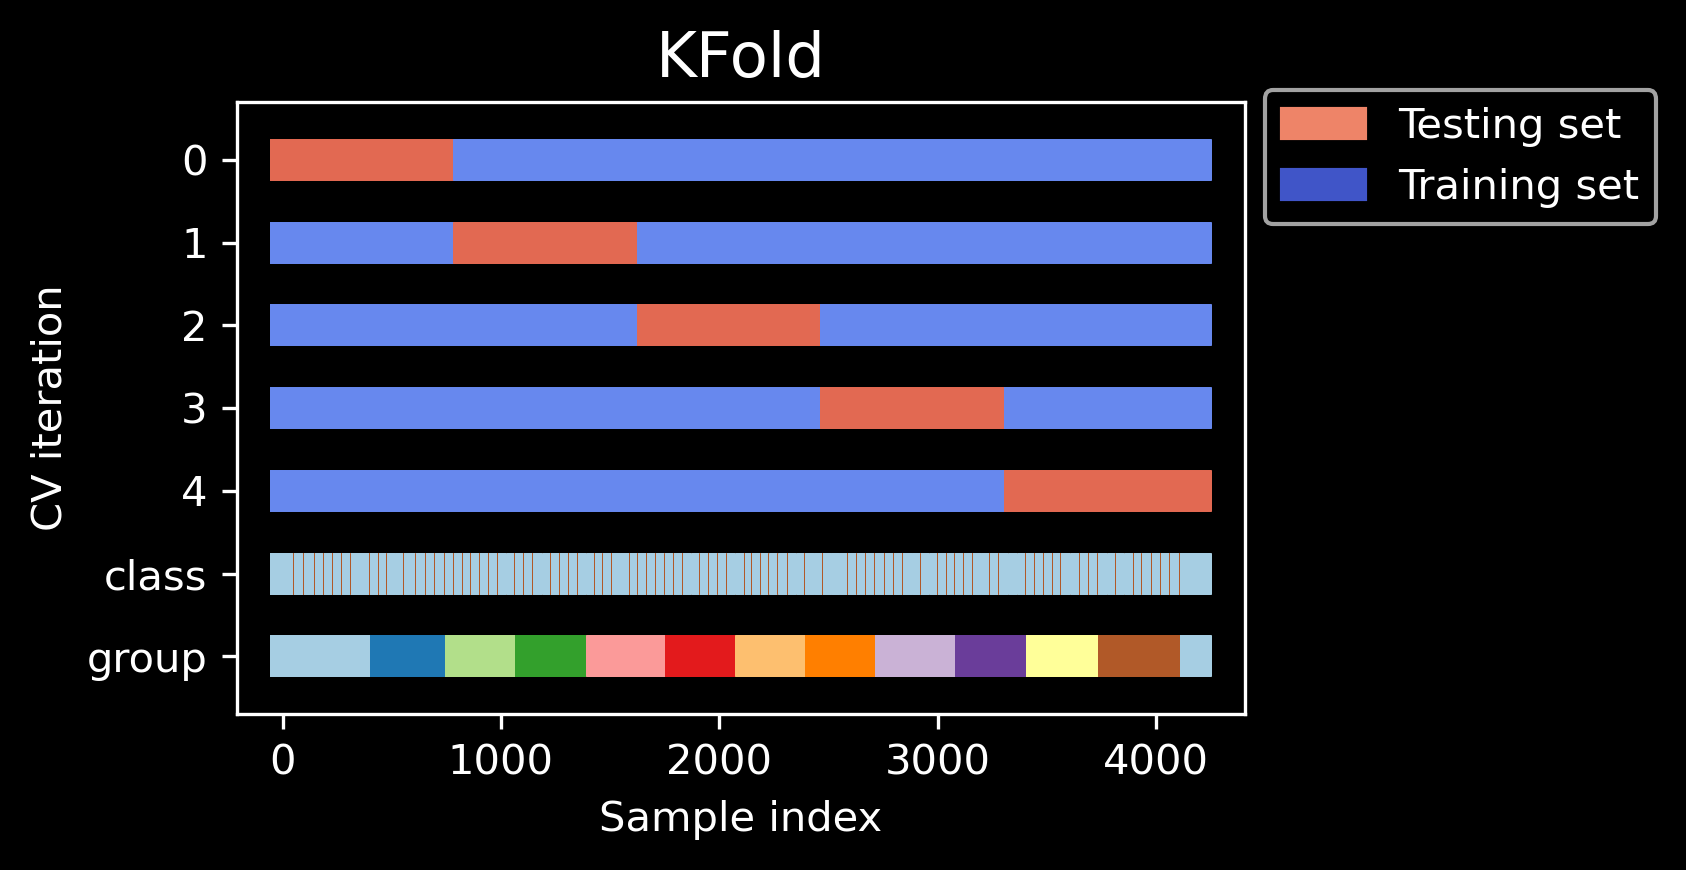

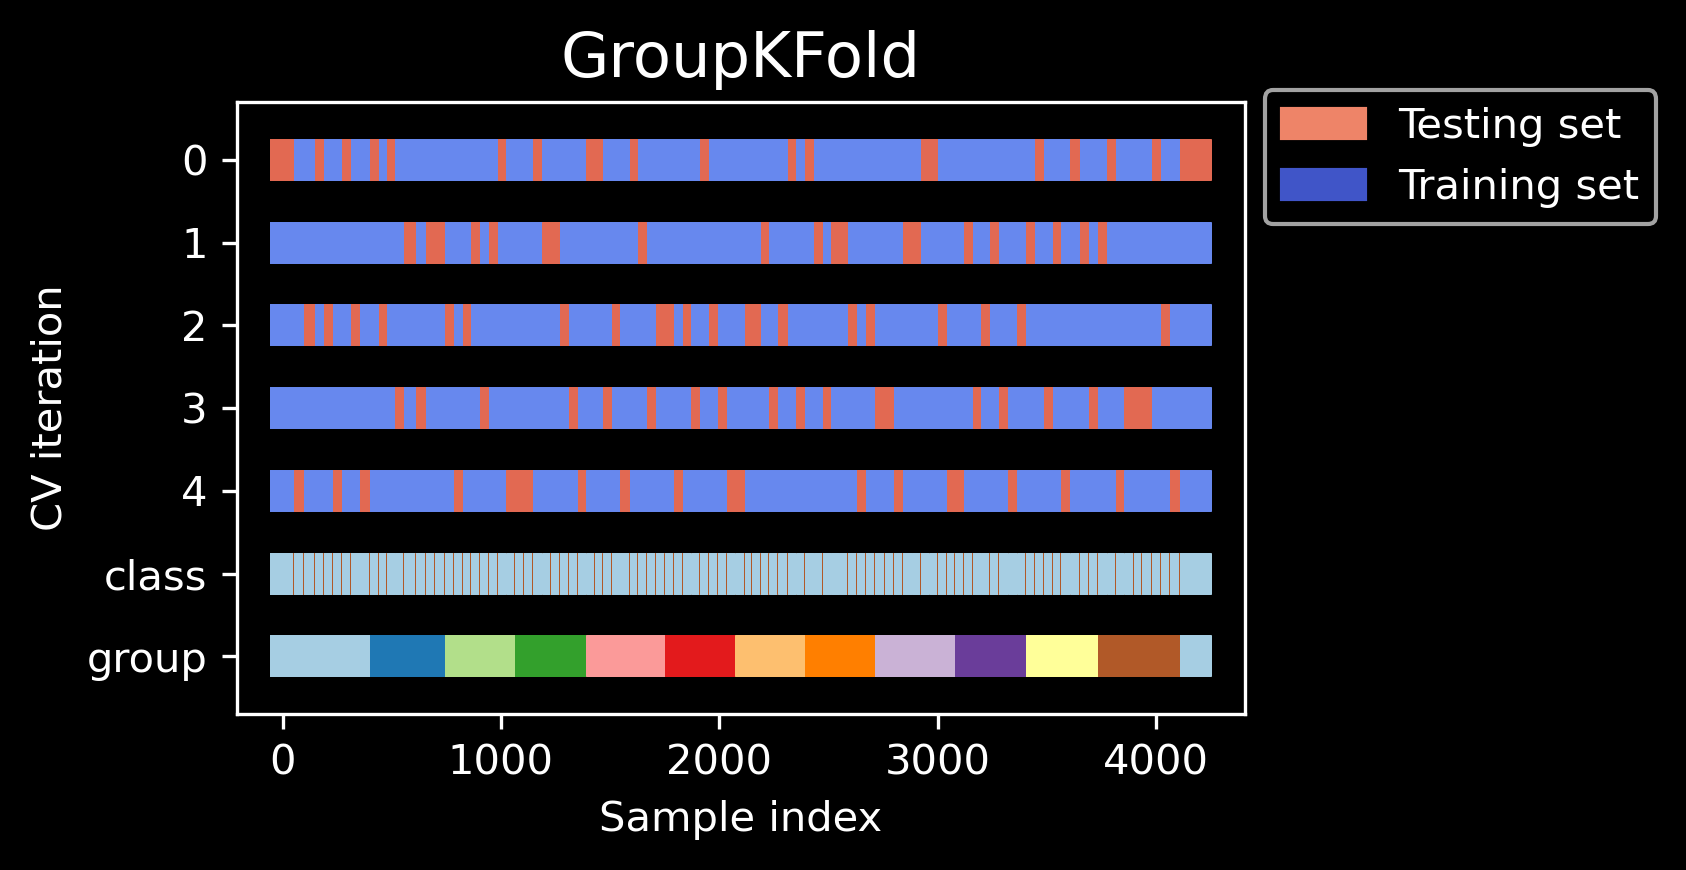

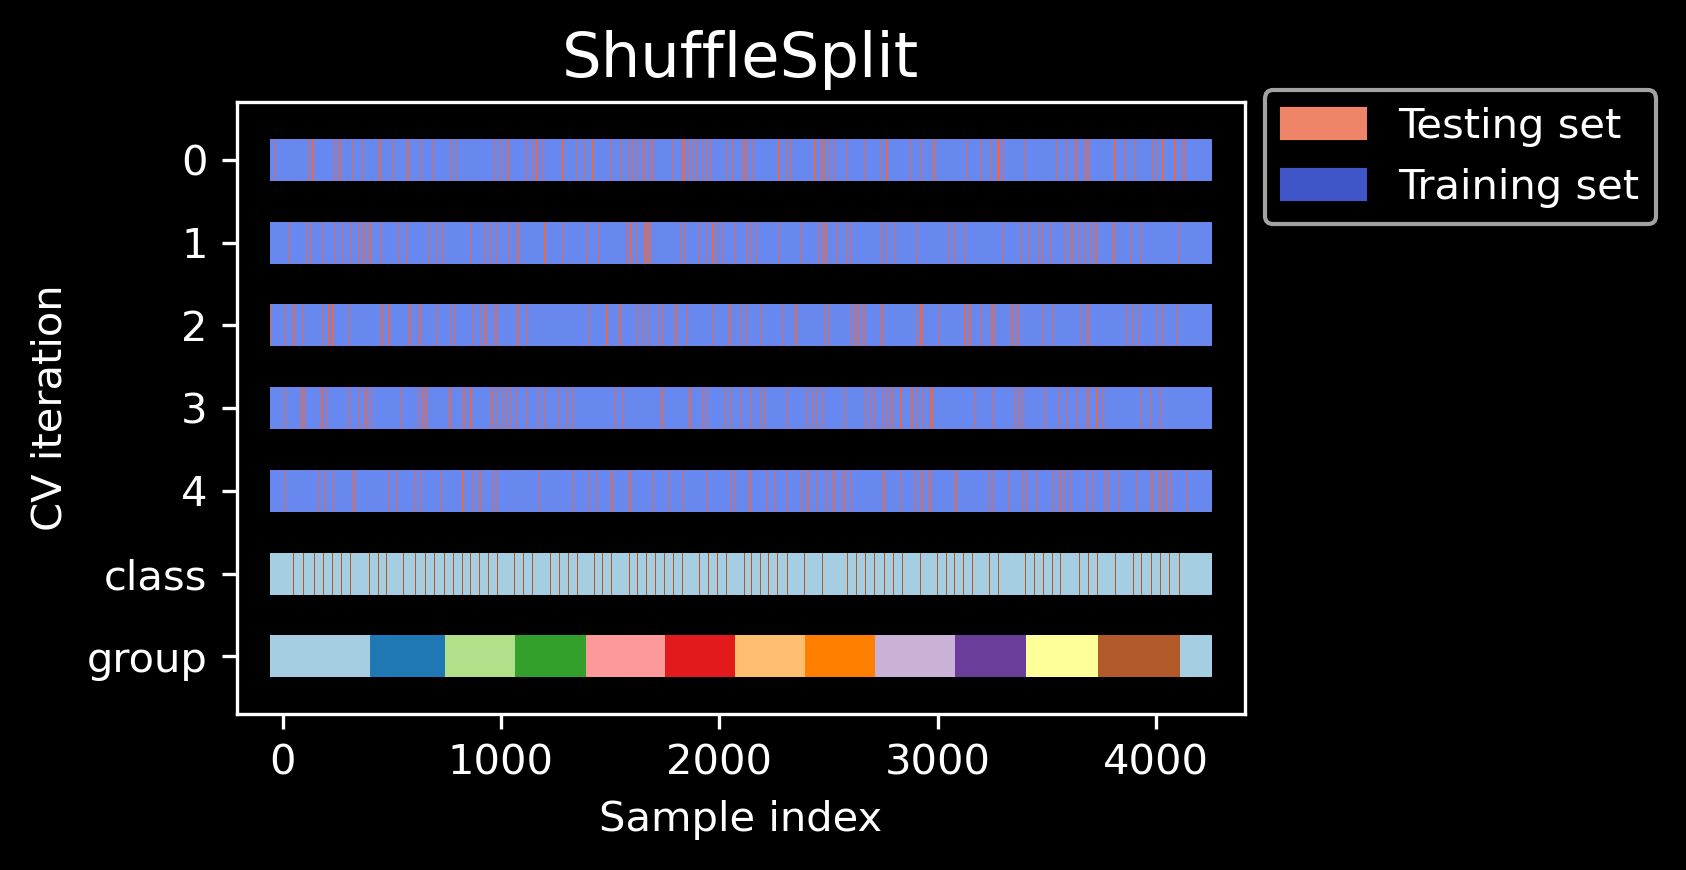

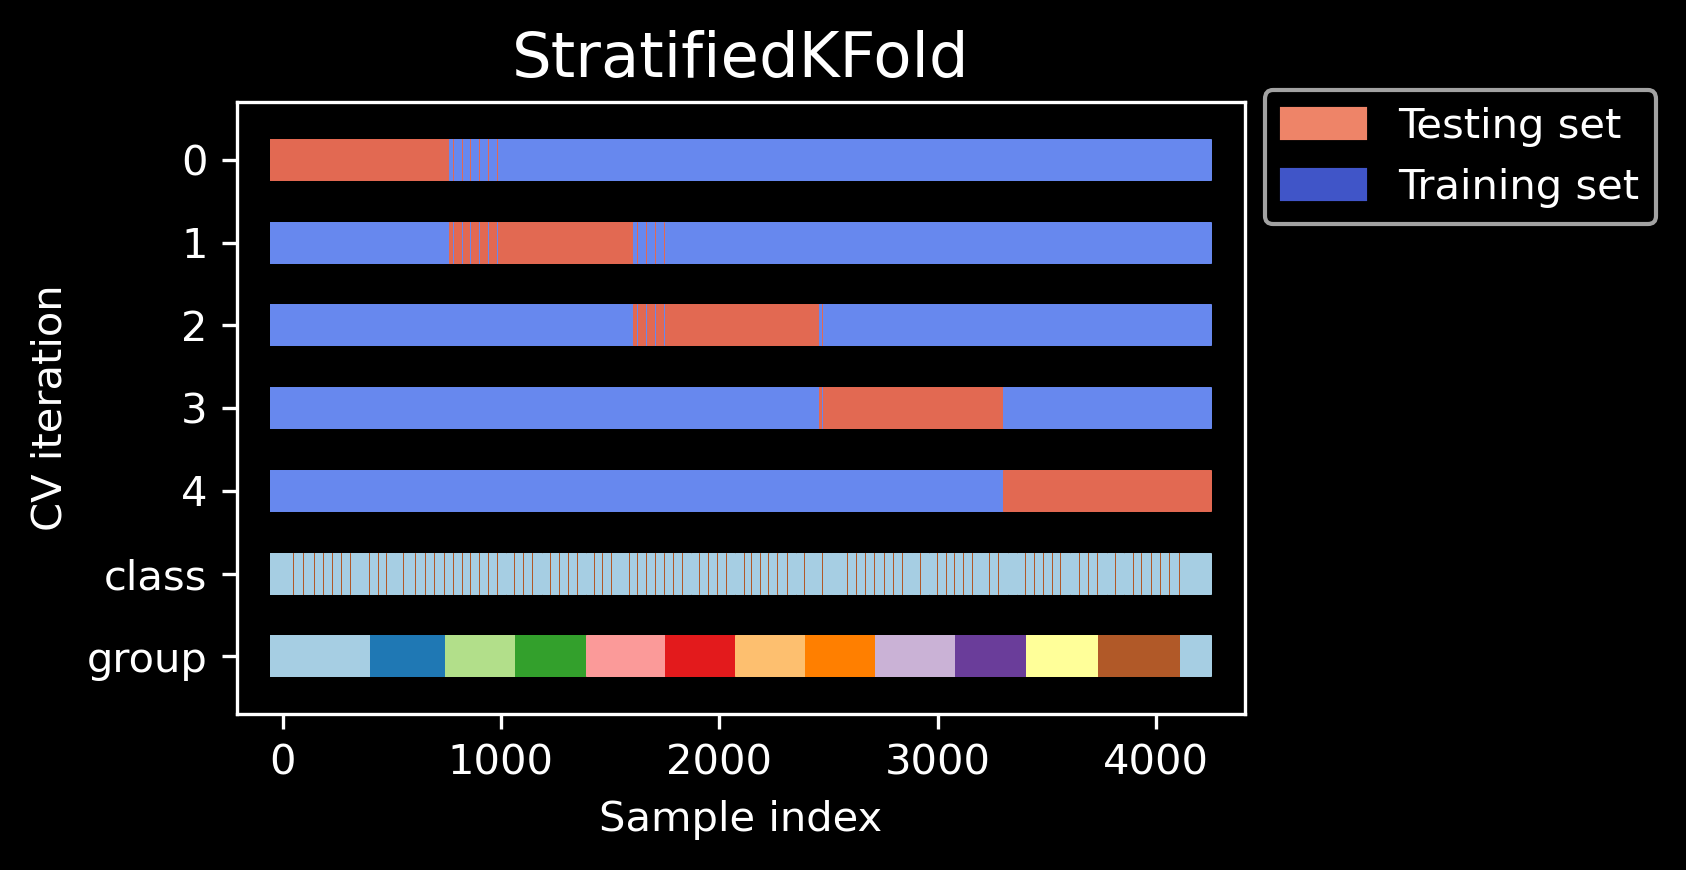

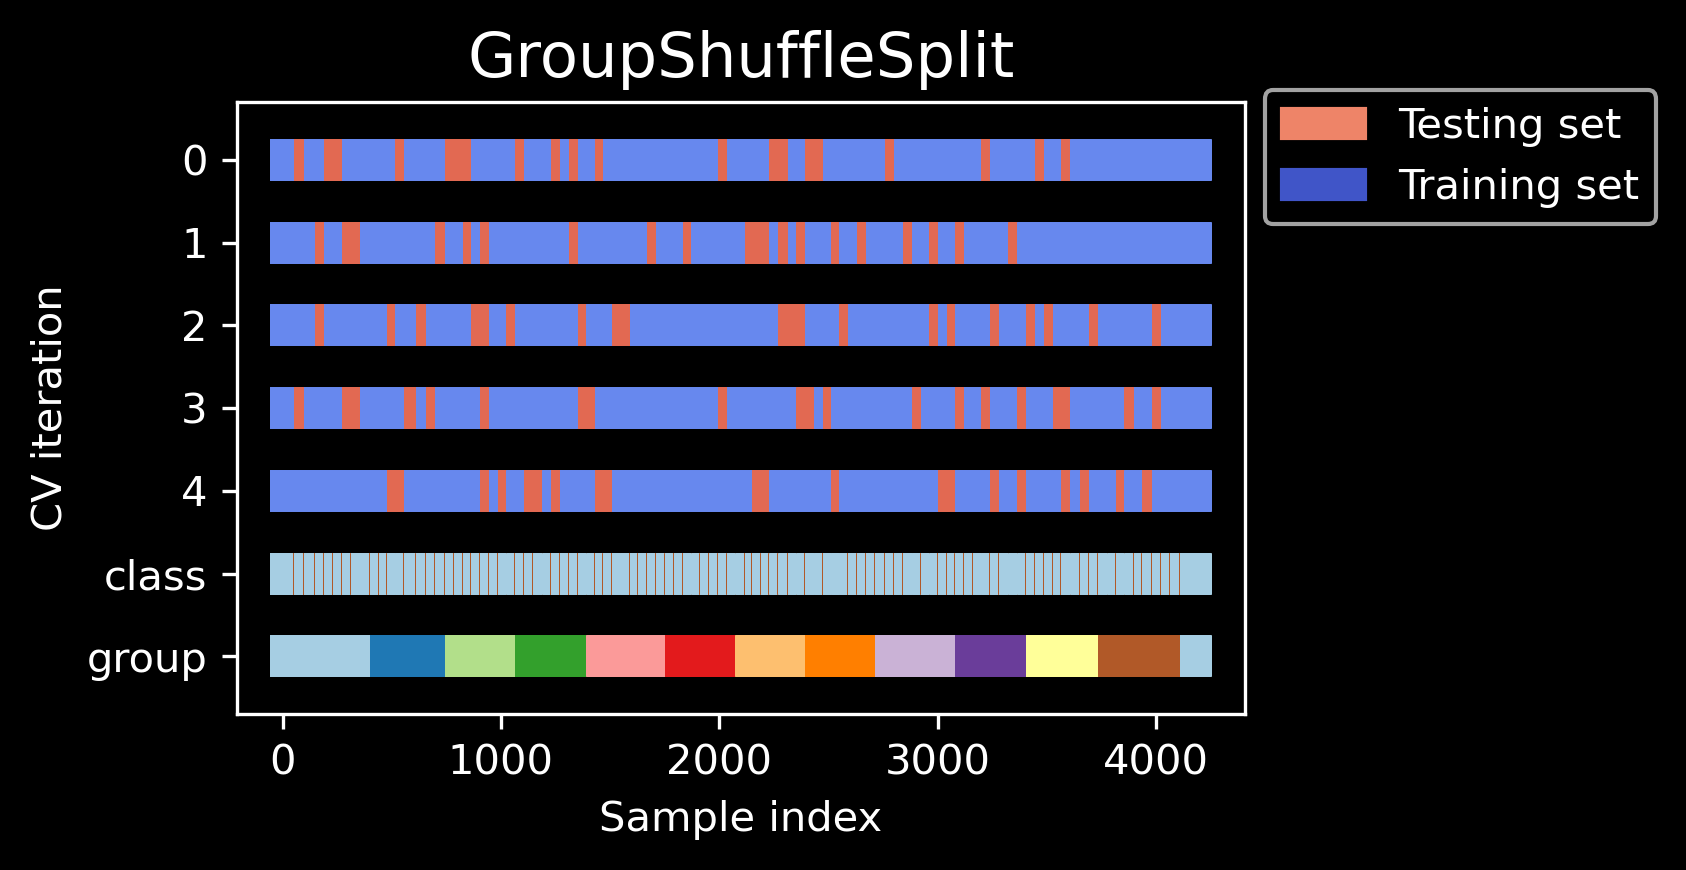

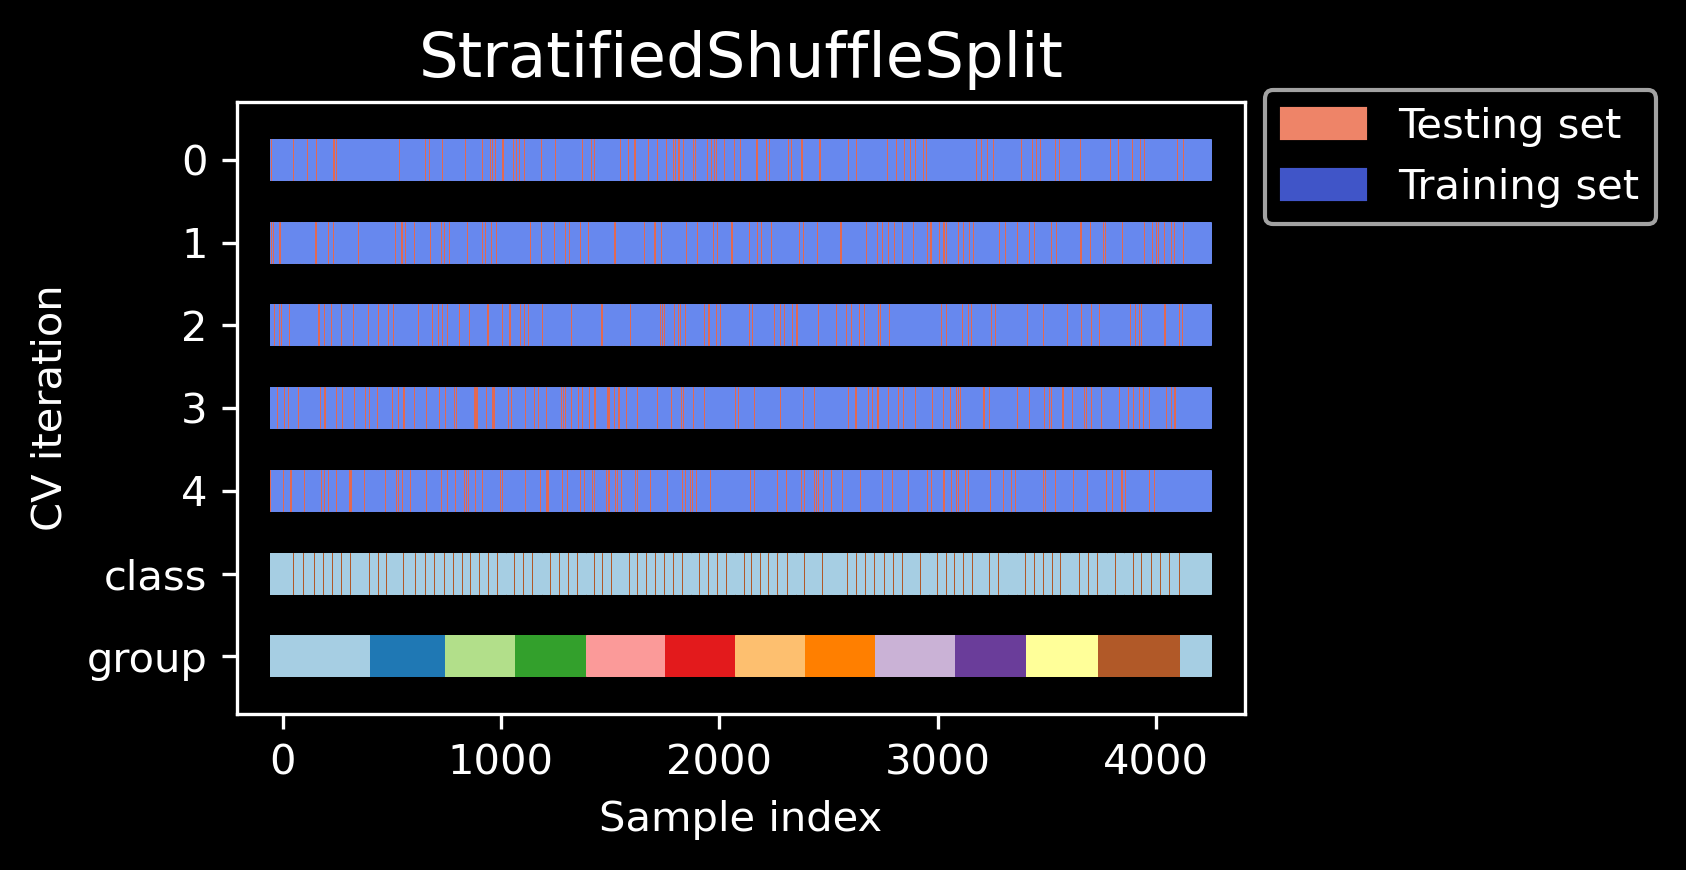

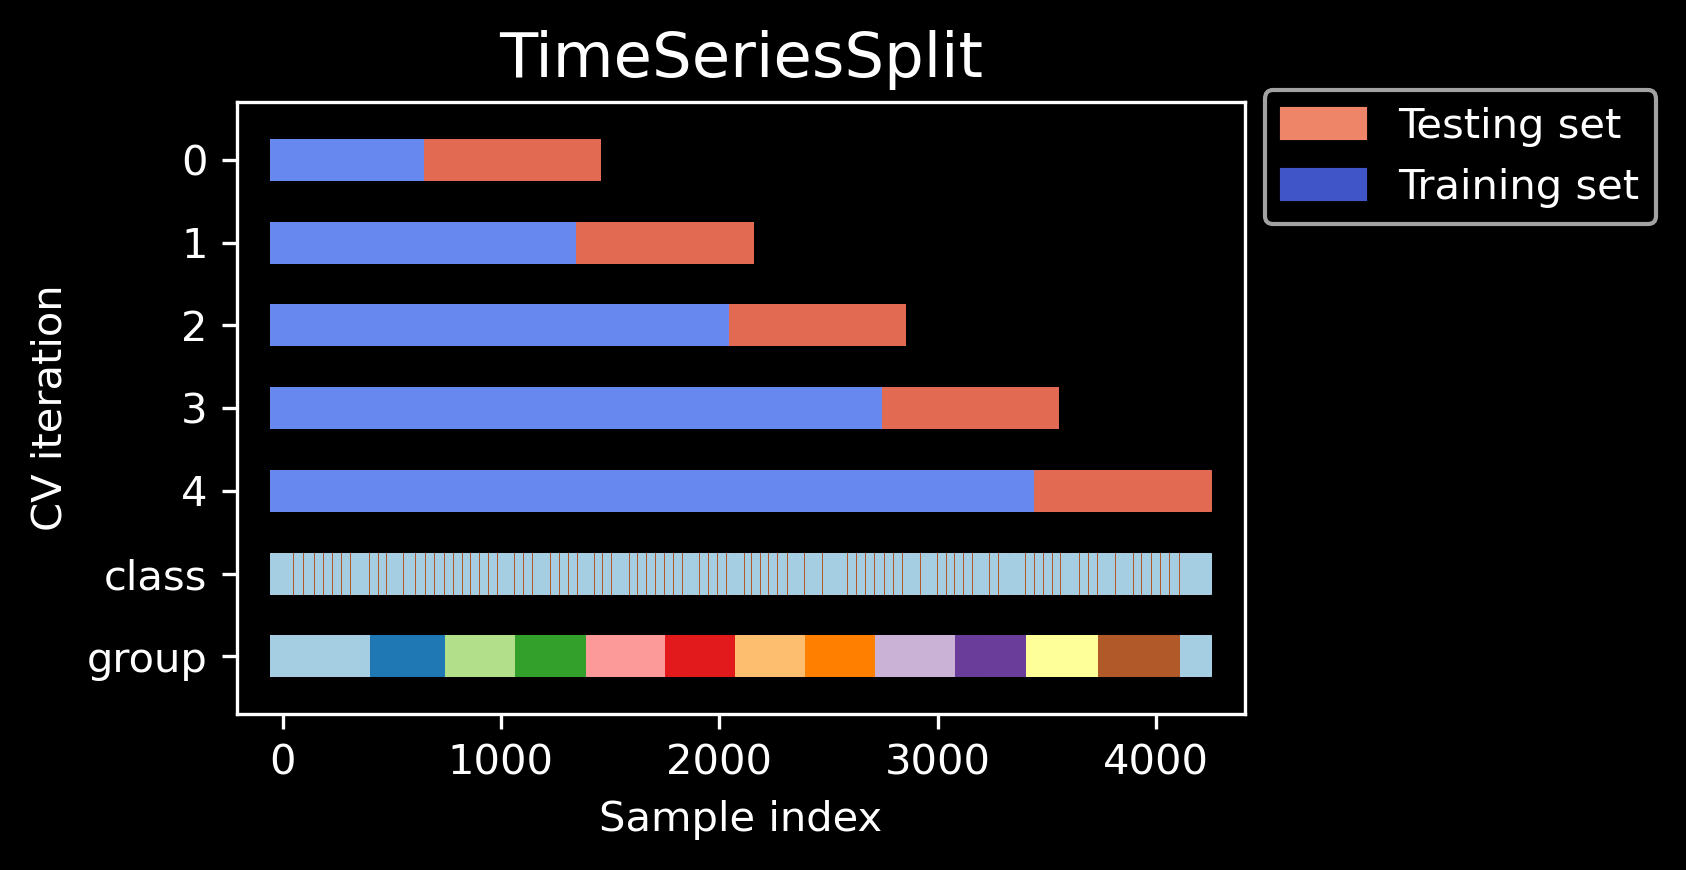

In [116]:
cvs = [KFold, GroupKFold, ShuffleSplit, StratifiedKFold,
       GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3), dpi =300)
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
plt.show()